<center>
<img src="../img/ml_theme.png">
# Школа данных "Билайн"
# "Прикладной анализ данных"
#### Интенсивный курс по изучению машинного обучения и анализа данных
<img src="../img/beeline_logo.jpg" height="240" width="240">
## Автор материала: преподаватель ФКН НИУ ВШЭ Кашницкий Юрий
</center>
Материал распространяется на условиях лицензии <a href="http://www.microsoft.com/en-us/openness/default.aspx#Ms-RL">Ms-RL</a>. Можно использовать в любых целях, кроме коммерческих, но с обязательным упоминанием автора материала и Школы Данных "Билайн".

# Семинар 13.
## Дополнительная часть. Практика. Деревья и лес решений.

**<a href="https://www.kaggle.com/c/titanic">Соревнование</a> Kaggle "Titanic: Machine Learning from Disaster".**

## 1. Визуальный анализ данных

In [2]:
from __future__ import division, print_function
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
%pylab inline
import seaborn as sns
figsize(12, 8)
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


**Функция для формирования csv-файла посылки на Kaggle**

In [3]:
def write_to_submission_file(predicted_labels, out_file, train_num=891,
                    target='Survived', index_label="PassengerId"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(train_num + 1,
                                                  train_num + 1 +
                                                  predicted_labels.shape[0]),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

**Считываем обучающую и тестовую выборки**

In [4]:
train_df = pd.read_csv("../data/titanic_train.csv") 
test_df = pd.read_csv("../data/titanic_test.csv") 

In [5]:
y = np.asarray(train_df['Survived'])

In [6]:
test_df.shape

(418, 11)

In [7]:
train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,NaN,C


In [8]:
train_df.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Graham, Mr. George Edward",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [9]:
test_df.describe(include='all')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Rosenbaum, Miss. Edith Louise",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


**Заполним пропуски медианными значениями**

In [10]:
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].median())
test_df['Age'] = test_df['Age'].fillna(train_df['Age'].median())
train_df['Embarked'] = train_df['Embarked'].fillna('S')
test_df['Fare'] = test_df['Fare'].fillna(train_df['Fare'].median())

**Постройте попарные зависимости признаков `Age`, `Fare`, `Pclass`, `Sex`, `SibSp`, `Parch`, `Embarked` и `Survived`. (метод `scatter_matrix ` Pandas или `pairplot` Seaborn).**

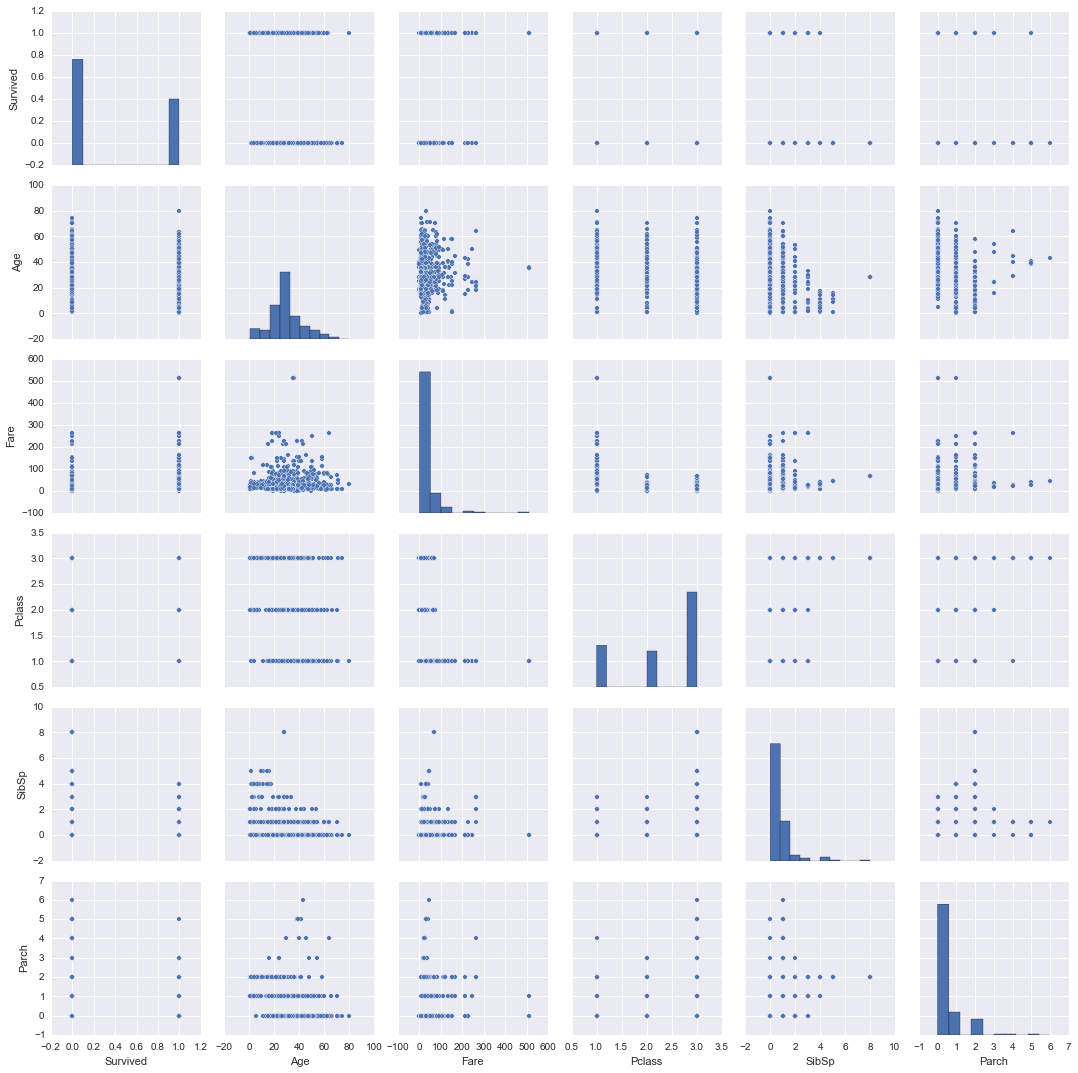

In [11]:
sns.pairplot(train_df[['Survived', 'Age', 'Fare', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']])

**Как плата за билет (`Fare`) зависит от класса каюты (`Pclass`)? Постройте boxplot.**

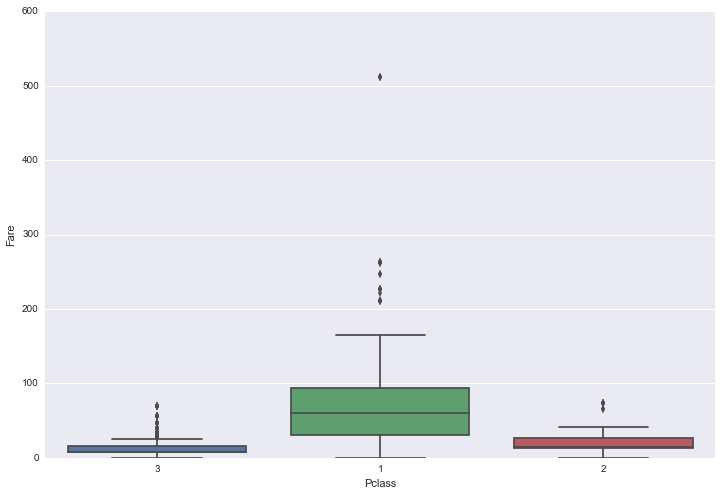

In [12]:
sns.boxplot(x='Pclass', y='Fare', data=train_df)

**Такой boxplot получается не очень красивым из-за выбросов.** 

**Опционально: создайте признак `Fare_no_out` - стоимости без выбросов, в котором исключаются стоимости, отличающиеся от средней по классу более чем на 3 стандартных отклонения. Важно: Надо исключать выбросы именно в зависимости от класса каюты. Иначе исключаться будут только самые большие (1 класс) и малые (3 класс) стоимости.**

In [80]:
train_df['Fare_no_out'] = train_df['Fare']
fare_pclass1 = train_df[train_df['Pclass'] == 1]['Fare']
fare_pclass2 = train_df[train_df['Pclass'] == 2]['Fare']
fare_pclass3 = train_df[train_df['Pclass'] == 3]['Fare']
fare_pclass1_no_outliers = fare_pclass1[(fare_pclass1 - fare_pclass1.mean()).abs()  < 2 * fare_pclass1.std()]
fare_pclass2_no_outliers = fare_pclass2[(fare_pclass2 - fare_pclass2.mean()).abs()  < 2 * fare_pclass2.std()]
fare_pclass3_no_outliers = fare_pclass3[(fare_pclass3 - fare_pclass3.mean()).abs()  < 2 * fare_pclass3.std()]
train_df['Fare_no_out'] = fare_pclass1_no_outliers.append(fare_pclass2_no_outliers).append(fare_pclass3_no_outliers)

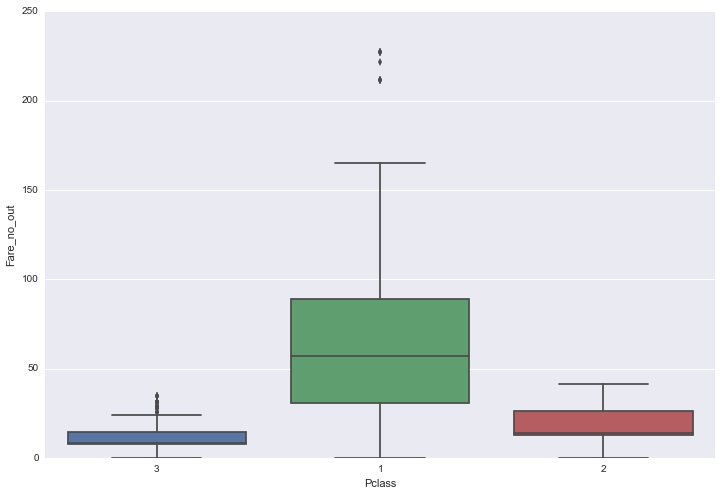

In [82]:
sns.boxplot(x='Pclass', y='Fare_no_out', data=train_df)

**Каково соотношение погибших и выживших в зависимости от пола? Отобразите c помощью Seaborn.countplot c аргументом hue.**

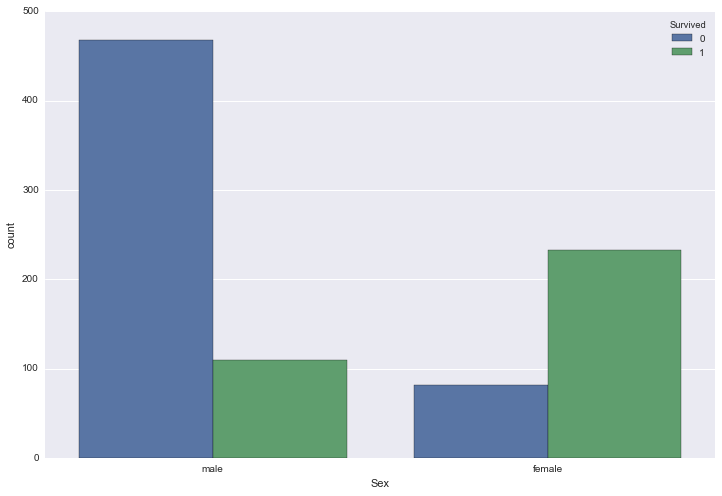

In [30]:
sns.countplot(x="Sex", hue="Survived", data=train_df)

**Каково соотношение погибших и выживших в зависимости от класса каюты? Отобразите c помощью Seaborn.countplot c аргументом hue.****

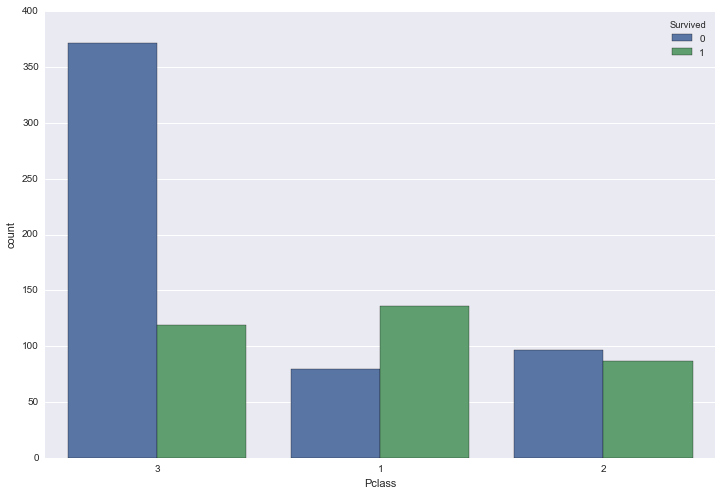

In [31]:
sns.countplot(x="Pclass", hue="Survived", data=train_df)

**Как факт выживания зависит от возраста пассажира? Проверьте (графически) предположение, что молодые чаще выживали.**

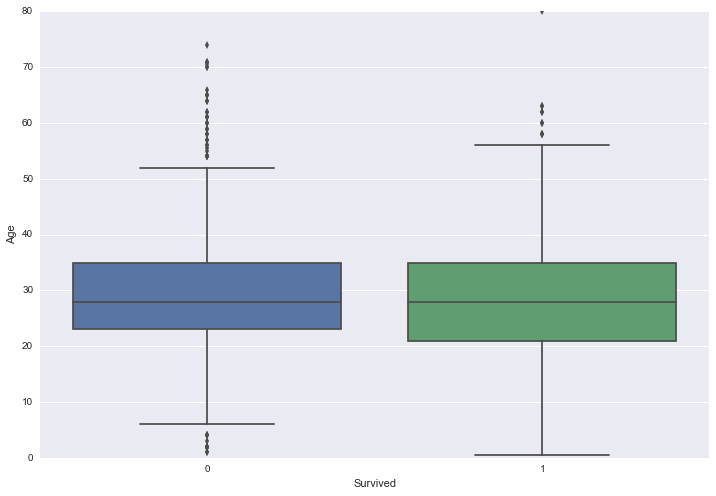

In [34]:
sns.boxplot(x='Survived', y='Age', data=train_df)

## 2. Прогноз выживания (классификация)

**Создаем бинарные признаки из категориальных `Pclass`, `Sex`, `SibSp`, `Parch`, и `Embarked`.**

In [14]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['Pclass'], prefix="PClass"),
                      pd.get_dummies(train_df['Sex'], prefix="Sex"),
                      pd.get_dummies(train_df['SibSp'], prefix="SibSp"),
                      pd.get_dummies(train_df['Parch'], prefix="Parch"),
                     pd.get_dummies(train_df['Embarked'], prefix="Embarked")],
                     axis=1)
test_df = pd.concat([test_df, pd.get_dummies(test_df['Pclass'], prefix="PClass"),
                      pd.get_dummies(test_df['Sex'], prefix="Sex"),
                      pd.get_dummies(test_df['SibSp'], prefix="SibSp"),
                      pd.get_dummies(test_df['Parch'], prefix="Parch"),
                    pd.get_dummies(test_df['Embarked'], prefix="Embarked")],
                     axis=1)

In [15]:
train_df.drop(['Survived', 'Pclass', 'Name', 'Sex', 'SibSp', 
               'Parch', 'Ticket', 'Cabin', 'Embarked', 'PassengerId'], axis=1, inplace=True)
test_df.drop(['Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked', 'PassengerId'], axis=1, inplace=True)

**В тестовой выборке появляется новое значение Parch = 9, которого нет в обучающей выборке. Проигнорируем его.**

In [16]:
train_df.shape, test_df.shape

((891, 24), (418, 25))

In [17]:
set(test_df.columns) - set(train_df.columns)

{'Parch_9'}

In [18]:
test_df.drop(['Parch_9'], axis=1, inplace=True)

In [19]:
train_df.head()

,Age,Fare,PClass_1,PClass_2,PClass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,SibSp_2,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_C,Embarked_Q,Embarked_S
0,22,7.2500,0,0,1,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,1
1,38,71.2833,1,0,0,1,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
2,26,7.9250,0,0,1,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
3,35,53.1000,1,0,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
4,35,8.0500,0,0,1,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,1


In [20]:
test_df.head()

,Age,Fare,PClass_1,PClass_2,PClass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,SibSp_2,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_C,Embarked_Q,Embarked_S
0,34.5,7.8292,0,0,1,0,1,1,0,0,...,1,0,0,0,0,0,0,0,1,0
1,47.0,7.0000,0,0,1,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
2,62.0,9.6875,0,1,0,0,1,1,0,0,...,1,0,0,0,0,0,0,0,1,0
3,27.0,8.6625,0,0,1,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,1
4,22.0,12.2875,0,0,1,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1


## 2.1. Дерево решений без настройки параметров 

**Обучите на имеющейся выборке дерево решений (DecisionTreeClassifier) максимальной глубины 3**

In [21]:
tree = DecisionTreeClassifier(max_depth=3)

tree.fit(train_df, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

**Сделайте с помощью полученной модели прогноз для тестовой выборки **

In [22]:
predictions = tree.predict(test_df)

**Сформируйте файл посылки и отправьте на Kaggle**

In [23]:
write_to_submission_file(predictions, '../output/titanic_tree_depth3.csv')

**У такой посылки результат на публичной тестовой выборке - 0.77512.**

## 2.2.  Дерево решений с настройкой параметров 

**Обучите на имеющейся выборке дерево решений (DecisionTreeClassifier). Максимальную глубину и минимальное число элементов в листе настройте с помощью GridSearchCV**

In [19]:
# tree params for grid search
tree_params = {'criterion': ('gini', 'entropy'), 
               'max_depth': list(range(1,5)), 
               'min_samples_leaf': list(range(1,5))}

locally_best_tree = GridSearchCV(DecisionTreeClassifier(), 
                                 tree_params, 
                                 verbose=True, n_jobs=1, cv=5)
locally_best_tree.fit(train_df, y)

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    0.8s finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'criterion': ('gini', 'entropy'), 'max_depth': [1, 2, 3, 4], 'min_samples_leaf': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=True)

In [20]:
print("Best params:", locally_best_tree.best_params_)
print("Best cross validaton score", locally_best_tree.best_score_)

Best params: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1}
Best cross validaton score 0.817059483726


**Сделайте с помощью полученной модели прогноз для тестовой выборки **

In [24]:
predictions = locally_best_tree.predict(test_df)

**Сформируйте файл посылки и отправьте на Kaggle**

In [25]:
write_to_submission_file(predictions, '../output/titanic_tree_ent_depth3.csv')

**У такой посылки результат на публичной тестовой выборке - 0.78469.**

## 2.3. Случайный лес с настройкой параметров 

**Обучите на имеющейся выборке случайный лес (RandomForestClassifier). Число деревьев, максимальную глубину и минимальное число элементов в листе настройте с помощью GridSearchCV**

In [27]:
# tree params for grid search
forest_params = {'n_estimators': [5, 100, 500, 1000],
               'criterion': ('gini', 'entropy'), 
               'max_depth': list(range(1,5)), 
               'min_samples_leaf': list(range(1,5))}

locally_best_forest = GridSearchCV(RandomForestClassifier(), 
                                 forest_params, 
                                 verbose=True, n_jobs=1, cv=5)
locally_best_forest.fit(train_df, y)

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   12.9s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:   52.9s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:  2.0min
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:  2.2min finished


Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [60, 80, 100], 'criterion': ('gini', 'entropy'), 'max_depth': [1, 2, 3, 4], 'min_samples_leaf': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=True)

In [28]:
print("Best params:", locally_best_forest.best_params_)
print("Best cross validaton score", locally_best_forest.best_score_)

Best params: {'n_estimators': 80, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 3}
Best cross validaton score 0.819304152637


**Сделайте с помощью полученной модели прогноз для тестовой выборки **

In [29]:
forest_predictions = locally_best_forest.predict(test_df)

**Сформируйте файл посылки и отправьте на Kaggle**

In [31]:
write_to_submission_file(forest_predictions, '../output/titanic_forest_ent_n80_dep4.csv')

**У такой посылки результат на публичной тестовой выборке - 0.77512 AUC.**

## Ссылки:

 - <a href="https://www.kaggle.com/c/titanic">Соревнование</a> Kaggle "Titanic: Machine Learning from Disaster"
 - <a href="https://www.dataquest.io/mission/74/getting-started-with-kaggle/">Тьюториал</a> Dataquest по задаче Kaggle "Titanic: Machine Learning from Disaster"